In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Set plot style for better visualization
import seaborn as sns
sns.set_theme(style="whitegrid")

In [2]:
# --- Load Data ---
# Make sure 'House Price Prediction Dataset_11.csv' is in the same directory.
filename = "House Price Prediction Dataset_11.csv"

try:
    df = pd.read_csv(filename)
    print("Dataset loaded successfully.")
    print("\nFirst 5 rows:")
    display(df.head())
except FileNotFoundError:
    print(f"Error: File '{filename}' not found. Please upload it.")

# --- Preprocessing if data loaded ---
if 'df' in locals():
    # Remove rows with missing values
    df = df.dropna()

    # Select relevant features
    # We use .values to get numpy arrays for manual implementation
    X1 = df["Area"].values
    X2 = df["Bedrooms"].values
    # Encode categorical 'Location' to numeric codes
    X3 = df["Location"].astype("category").cat.codes.values
    y = df["Price"].values

    # --- Normalization (Standard Scaling) ---
    # Important for Gradient Descent convergence
    X1 = (X1 - np.mean(X1)) / np.std(X1)
    X2 = (X2 - np.mean(X2)) / np.std(X2)
    X3 = (X3 - np.mean(X3)) / np.std(X3)

    print("\nData Preprocessing Complete.")
    print(f"Total samples: {len(y)}")

Dataset loaded successfully.

First 5 rows:


,Id,Area,Bedrooms,Bathrooms,Floors,YearBuilt,Location,Condition,Garage,Price
0,1,1360,5,4,3,1970,Downtown,Excellent,No,149919
1,2,4272,5,4,3,1958,Downtown,Excellent,No,424998
2,3,3592,2,2,3,1938,Downtown,Good,No,266746
3,4,966,4,2,2,1902,Suburban,Fair,Yes,244020
4,5,4926,1,4,2,1975,Downtown,Fair,Yes,636056



Data Preprocessing Complete.
Total samples: 2000


In [3]:
# --- Hyperparameters ---
alpha = 0.01      # Learning rate (step size for gradient descent)
epochs = 1000     # Number of training iterations
k_folds = 5       # Number of cross-validation folds

# Initialize K-Fold cross-validator
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store results from each fold
mse_scores = []
r2_scores = []
cost_history_all = []

print(f"Setup complete: {k_folds}-Fold CV, alpha={alpha}, epochs={epochs}")

Setup complete: 5-Fold CV, alpha=0.01, epochs=1000


In [4]:
if 'X1' in locals():
    print("Starting K-Fold Cross-Validation Training...\n")
    fold = 1

    # Loop through each fold
    for train_index, test_index in kf.split(X1):
        print(f"🔹 Fold {fold}/{k_folds}...")

        # --- 1. Split data for this fold ---
        # Training data for this fold
        X1_train, X1_test = X1[train_index], X1[test_index]
        X2_train, X2_test = X2[train_index], X2[test_index]
        X3_train, X3_test = X3[train_index], X3[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # --- 2. Initialize parameters for this fold ---
        # Reset weights to 0 for each new fold
        m1 = m2 = m3 = c = 0.0
        n_train = len(y_train)
        cost_history = []

        # --- 3. Gradient Descent Training ---
        for i in range(epochs):
            # Forward pass: Predict prices
            y_pred = m1 * X1_train + m2 * X2_train + m3 * X3_train + c

            # Calculate error
            error = y_pred - y_train

            # Calculate cost (Mean Squared Error / 2)
            cost = (1 / (2 * n_train)) * np.sum(error ** 2)
            cost_history.append(cost)

            # Backward pass: Calculate gradients
            dm1 = (1 / n_train) * np.sum(error * X1_train)
            dm2 = (1 / n_train) * np.sum(error * X2_train)
            dm3 = (1 / n_train) * np.sum(error * X3_train)
            dc = (1 / n_train) * np.sum(error)

            # Update weights
            m1 -= alpha * dm1
            m2 -= alpha * dm2
            m3 -= alpha * dm3
            c -= alpha * dc

        # Store cost history for this fold
        cost_history_all.append(cost_history)

        # --- 4. Evaluate on Test Data for this fold ---
        y_pred_test = m1 * X1_test + m2 * X2_test + m3 * X3_test + c
        
        # Calculate MSE
        mse = np.mean((y_pred_test - y_test) ** 2)
        mse_scores.append(mse)

        # Calculate R² Score
        ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
        ss_residual = np.sum((y_test - y_pred_test) ** 2)
        r2 = 1 - (ss_residual / ss_total)
        r2_scores.append(r2)

        print(f"   -> MSE: {mse:.4f}")
        print(f"   -> R² Score: {r2*100:.2f}%")
        fold += 1

    print("\nTraining complete.")

Starting K-Fold Cross-Validation Training...

🔹 Fold 1/5...
   -> MSE: 77833690575.4628
   -> R² Score: -0.04%
🔹 Fold 2/5...
   -> MSE: 77962185407.1871
   -> R² Score: -0.89%
🔹 Fold 3/5...
   -> MSE: 75758006691.8145
   -> R² Score: -0.65%
🔹 Fold 4/5...
   -> MSE: 78684184027.4889
   -> R² Score: -1.33%
🔹 Fold 5/5...
   -> MSE: 73164753116.4794
   -> R² Score: -0.44%

Training complete.


In [5]:
if 'mse_scores' in locals() and len(mse_scores) > 0:
    print("========================================")
    print("✅ FINAL CROSS-VALIDATION RESULTS")
    print("========================================")
    print(f"Average MSE across {k_folds} folds: {np.mean(mse_scores):.4f}")
    print(f"Average R² Score across {k_folds} folds: {np.mean(r2_scores) * 100:.2f}%")

    print("\nFinal Trained Parameters (from last fold):")
    print(f"m1 (Area weight):      {m1:.4f}")
    print(f"m2 (Bedrooms weight):  {m2:.4f}")
    print(f"m3 (Location weight):  {m3:.4f}")
    print(f"c  (Bias/Intercept):   {c:.4f}")

✅ FINAL CROSS-VALIDATION RESULTS
Average MSE across 5 folds: 76680563963.6866
Average R² Score across 5 folds: -0.67%

Final Trained Parameters (from last fold):
m1 (Area weight):      4122.9065
m2 (Bedrooms weight):  674.8951
m3 (Location weight):  -5925.7519
c  (Bias/Intercept):   539240.6429


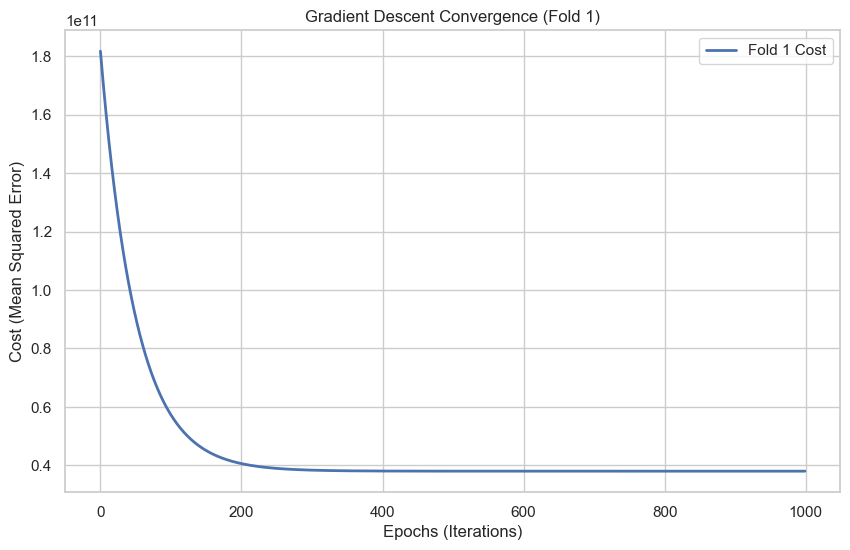

In [6]:
if 'cost_history_all' in locals() and len(cost_history_all) > 0:
    # Plot Cost Function Convergence for the first fold
    plt.figure(figsize=(10, 6))
    plt.plot(cost_history_all[0], linewidth=2, label='Fold 1 Cost')
    plt.title("Gradient Descent Convergence (Fold 1)")
    plt.xlabel("Epochs (Iterations)")
    plt.ylabel("Cost (Mean Squared Error)")
    plt.grid(True)
    plt.legend()
    plt.show()

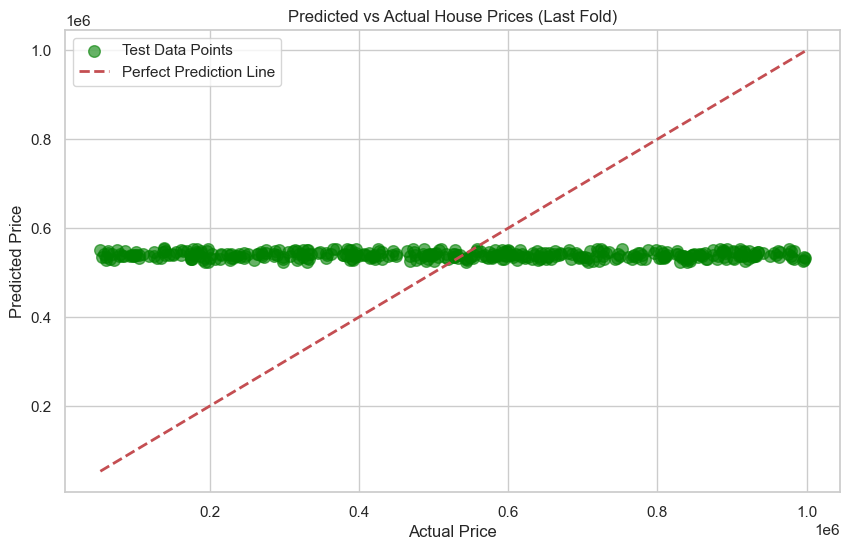

In [7]:
if 'y_test' in locals() and 'y_pred_test' in locals():
    # Plot Predicted vs Actual Price for the last fold
    plt.figure(figsize=(10, 6))
    
    # Scatter plot of actual vs predicted
    plt.scatter(y_test, y_pred_test, alpha=0.6, color='green', s=70, label='Test Data Points')
    
    # Plot perfect prediction line (y = x)
    min_val = min(np.min(y_test), np.min(y_pred_test))
    max_val = max(np.max(y_test), np.max(y_pred_test))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction Line')

    plt.title("Predicted vs Actual House Prices (Last Fold)")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.legend()
    plt.grid(True)
    plt.show()